In [1]:
import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
from tqdm import tqdm
from kalpana.plotting import plot_nc
from kalpana.export import fort14togdf
from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import matplotlib as mpl

In [51]:
xs = [-74.2, -73.5, -72.9, -72.8]
ys = [19.3133, 19.3133, 19.3133, 19.3133]

Remember that you had to edit the Kalpana source code for this extract_ts_from_nc to work with those files (adding extra split for ! NCD present in file). Remember to put in a pull request.

## ADCIRC+SWAN Run

In [9]:
timestep=43

In [10]:
super_shift = '../sims/Matthew16_base/'
root_swan = super_shift#+'adcirc+swan/'

In [11]:
## load the NetCDF dataset from a specified file path
nc_swan = netcdf.Dataset(root_swan+'fort.63.nc', 'r')
nc2 = netcdf.Dataset(root_swan+'fort.74.nc', 'r')

Text(0.5, 1.0, 'ADCIRC+SWAN - fort.63.nc at timestep: 43')

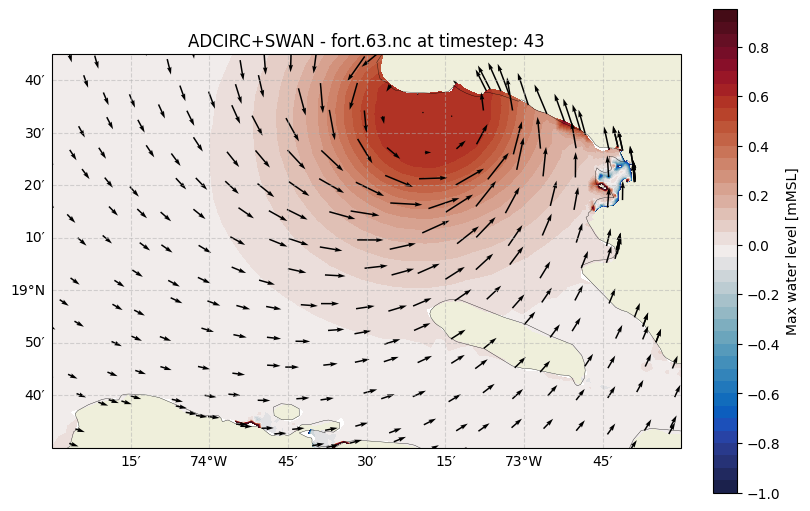

In [12]:
fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
plot_nc(nc_swan, 'zeta', levels = np.arange(-1., 1., 0.05), background_map = True, cbar = True, cb_label = 'Max water level [mMSL]', cmap = cmocean.cm.balance, ts = timestep,
        ncvec = nc2, dxvec=0.1, dyvec=0.1, vecsc=1000, ax = ax, fig = fig)
ax.set_xlim(-74.5, -72.5)
ax.set_ylim(18.5, 19.75)
ax.set_title('ADCIRC+SWAN - fort.63.nc at timestep: '+str(timestep))

In [13]:
nc_HS = netcdf.Dataset(root_swan+'swan_HS.63.nc', 'r')

variables = list(nc_HS.variables.keys())
swan_HS_list = nc_HS.variables['swan_HS'][:]
print('Min: ' + str(swan_HS_list.min()))
print('Avg: ' + str(swan_HS_list.mean()))
print('Max: ' + str(swan_HS_list.max()))

Min: 1.5191132658457257e-18
Avg: 2.4578192255245837
Max: 16.112295150756836


<GeoAxesSubplot: xlabel='Longitude [deg]', ylabel='Latitude [deg]'>

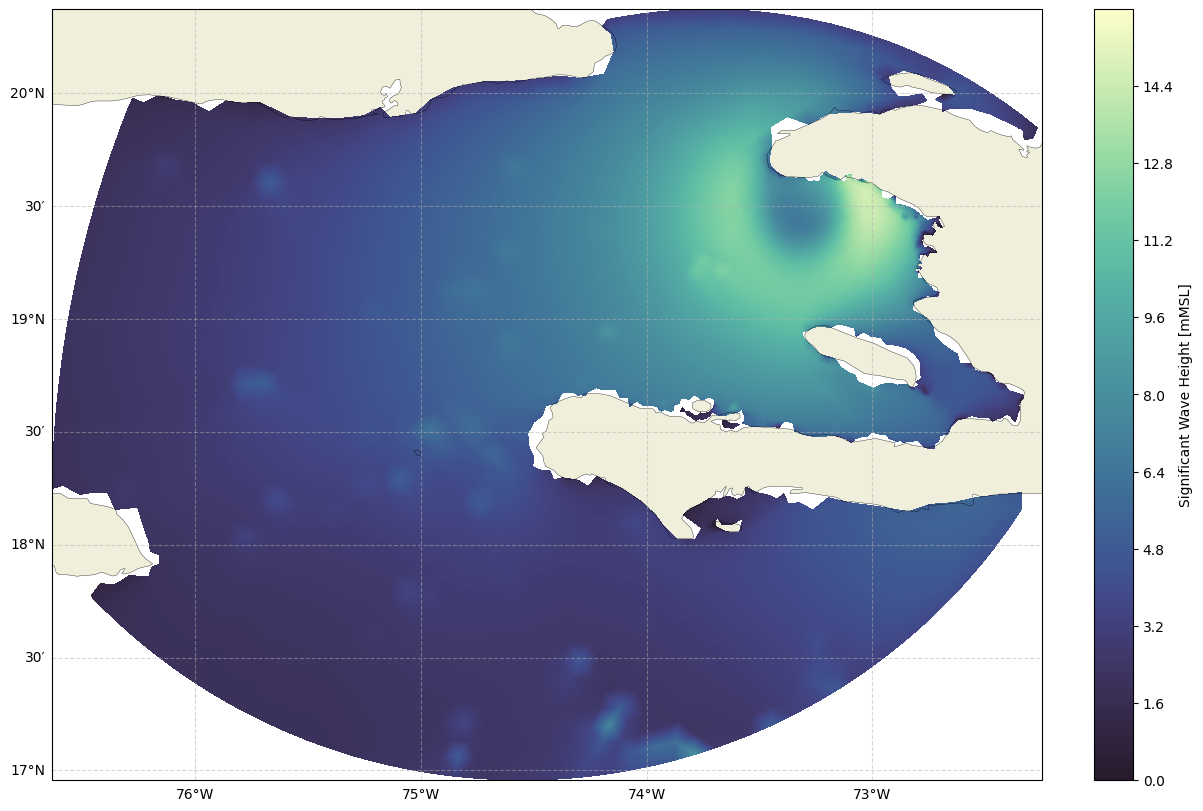

In [19]:
fig, ax = plt.subplots(figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)

plot_nc(nc_HS, 'swan_HS', levels = np.arange(0., 16., 0.01),
        background_map = True, cbar = True, cb_label = 'Significant Wave Height [mMSL]',
        cmap = cmocean.cm.deep_r, ts = timestep, ax = ax, fig = fig)

In [15]:
nc_DIR = netcdf.Dataset(root_swan+'swan_DIR.63.nc', 'r')
variables = list(nc_DIR.variables.keys())
swan_HS_DIR = nc_HS.variables['swan_HS'][:]
print('Min: ' + str(swan_HS_DIR.min()))
print('Avg: ' + str(swan_HS_DIR.mean()))
print('Max: ' + str(swan_HS_DIR.max()))

Min: 1.5191132658457257e-18
Avg: 2.4578192255245837
Max: 16.112295150756836


In [16]:
import pandas as pd

# Read the fort.22 file
filename = root_swan+"fort.22"  # Change this to your file path if needed
with open(filename, 'r') as f:
    lines = f.readlines()

# Extract data
lats = []
lons = []
times = []

for i in range(0, len(lines), 3):  # Process every 3rd line (first entry for each time)
    if i >= len(lines):
        break
        
    line = lines[i]
    parts = line.split(',')
    
    # Extract latitude
    lat_str = parts[6].strip()
    lat_val = float(lat_str[:-1]) / 10.0  # Convert to decimal degrees
    
    # Extract longitude
    lon_str = parts[7].strip()
    lon_val = -float(lon_str[:-1]) / 10.0  # Negative for W longitude
    
    # Extract time
    time_str = parts[2].strip()
    
    lats.append(lat_val)
    lons.append(lon_val)
    times.append(time_str)

# Create a DataFrame for better display in notebook
track_df = pd.DataFrame({
    'Time': times,
    'Latitude': lats,
    'Longitude': lons
})

Text(0.5, 1.0, 'Wave Direction (arrows) and Height at timestep: 43')

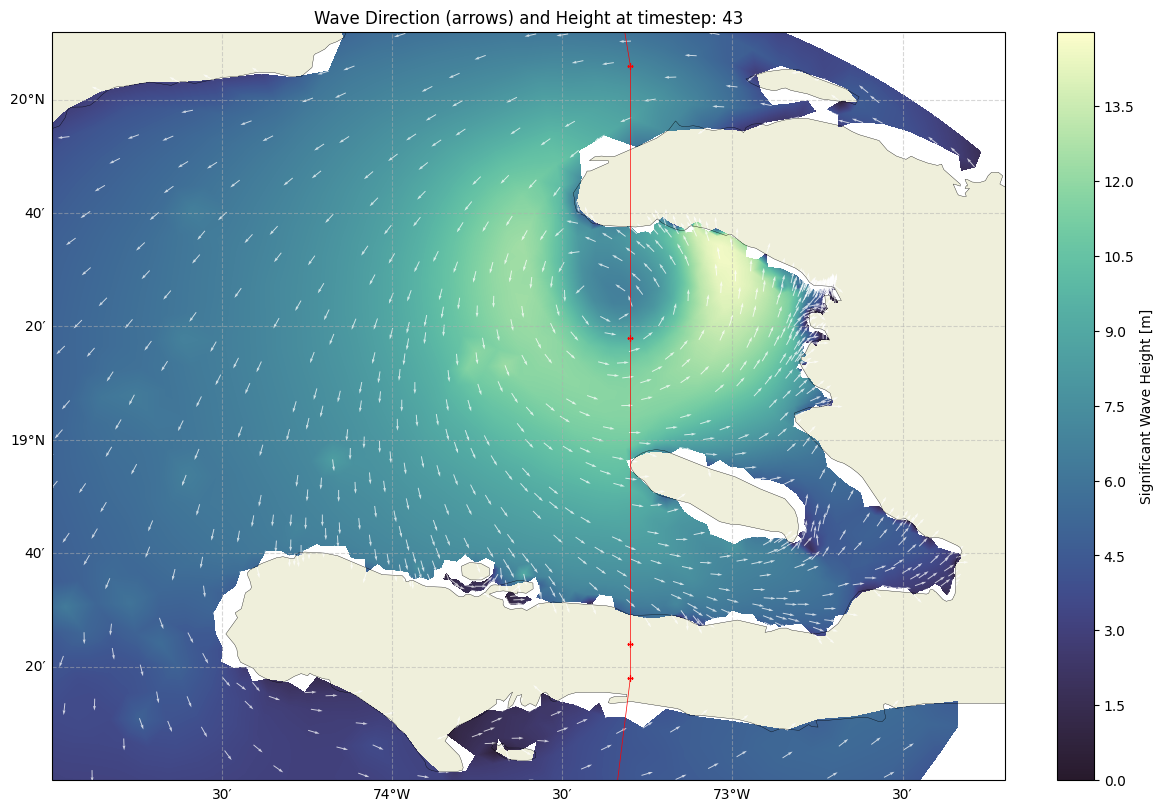

In [32]:
fig, ax = plt.subplots(figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        constrained_layout=True)
# significant wave height
plot_nc(nc_HS, 'swan_HS', levels = np.arange(0., 15., 0.01),
                background_map = True, cbar = True, cb_label = 'Significant Wave Height [m]',
                cmap = cmocean.cm.deep_r, ts = timestep, ax = ax, fig = fig)

# Get the coordinates and wave direction data
x = nc_DIR.variables['x'][:]
y = nc_DIR.variables['y'][:]
dir_data = nc_DIR.variables['swan_DIR'][timestep, :]

# Convert from oceanographic convention (where waves come from) to mathematical (where arrows point)
# In oceanographic convention, 0° is from North, 90° is from East
# For plotting arrows, we need to convert to mathematical angles where 0° is East and goes counterclockwise
#math_angles = (270 - dir_data) % 360
math_angles_rad = np.radians(dir_data)

# Calculate u and v components for arrows
u = np.cos(math_angles_rad)
v = np.sin(math_angles_rad)

# Skip points to make the plot clearer - show arrows at every nth point
n = 2
ax.quiver(x[::n], y[::n], u[::n], v[::n], 
                  scale=80, width=0.001, color='white', 
                  alpha=0.75,
                  transform=ccrs.PlateCarree())

# Plot trajectory line
ax.plot(lons, lats, '+-', linewidth=0.5, color='red', markersize=5)

# Plot points at each time step
ax.set_xlim(-75., -72.2)
ax.set_ylim(18., 20.2)

ax.set_title('Wave Direction (arrows) and Height at timestep: '+str(timestep))

## New stations positions using the arc method discussed with Mark.

make concentric circles out of the center of the mangrove forest, and put equally distanced points (5?) along each arc out of the mangroves toward the Gulf. This will make for easy transects building for analysis later.

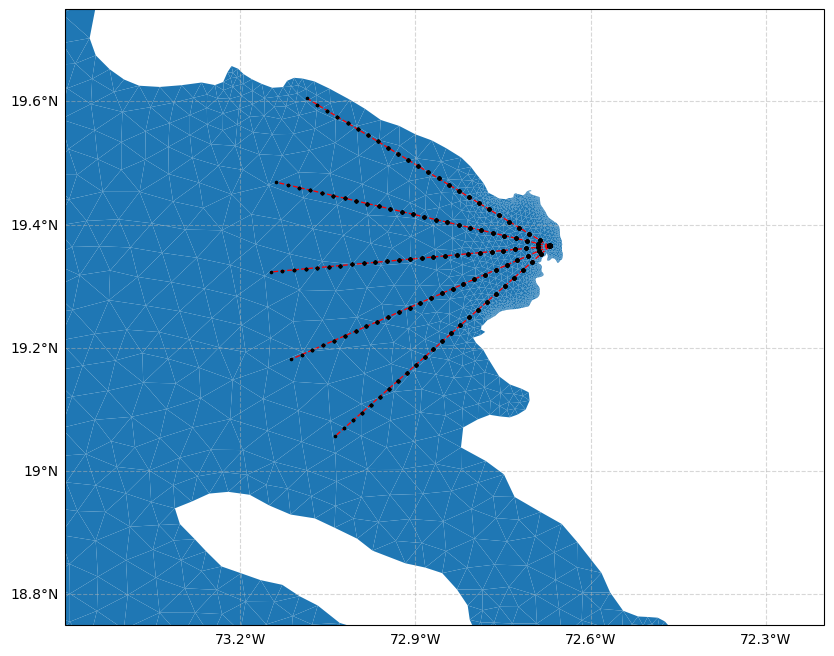

In [204]:
# Defining center of radius for arcs of observation stations
# Center is at the general midpoint of the mangrove forest in the open intertidal zone behind it.
center_x, center_y = -72.67, 19.365  

# List of radii (in NW increments) for the arcs of observation stations
radii = np.arange(0.02, 0.5, 0.02)  # Set distance between points to 0.05

#radius = 0.05  # Example radius

# Define the start and end angles of the arc (in degrees)
start_angle = 150  # Starting angle of the arc
end_angle = 220  # Ending angle of the arc
num_points = 5

# Generate angles for the points along the arc
angles = np.linspace(np.radians(start_angle), np.radians(end_angle), num_points)

arc_xs = [np.array([center_x])]
arc_ys = [np.array([center_y])]

mesh = fort14togdf(root_swan+'/fort.14', epsgIn=4326, epsgOut=4326, fileintype='fort.14')
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': ccrs.PlateCarree()})
mesh.plot(ax=ax)
ax.set_xlim(-73.5, -72.2)
ax.set_ylim(18.75, 19.75)

for i,radius in enumerate(radii):
    # Calculate the x and y coordinates of the points for a given arc
    arc_xs.append(center_x + radius * np.cos(angles))
    arc_ys.append(center_y + radius * np.sin(angles))

    # Plot arc on mesh
    ax.scatter(arc_xs[1:], arc_ys[1:], color = 'k', marker = '.', s = 10, zorder=5)
    ax.scatter(arc_xs[0], arc_ys[0], color = 'k', marker = '+', s = 15, zorder=5)

for i in range(num_points):
    ax.plot([arc_xs[0][0], arc_xs[-1][i]], [arc_ys[0][0], arc_ys[-1][i]], color = 'red', linestyle = '--', linewidth = 0.95)


gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mpl.ticker.MaxNLocator(nbins=5)
gl.ylocator = mpl.ticker.MaxNLocator(nbins=5)

In [ ]:

for point_x in arc_xs[1:]:
    xs.append(point_x[0])
for point_y in arc_ys[1:]:
    ys.append(point_y[0])

dfout2, rep = extract_ts_from_nc(nc_swan, list(zip(xs, ys)), variable = 'zeta', extractOut=False, closestIfDry=False)    

In [240]:
dfout2.iloc[45].name

Timestamp('2016-10-04 22:00:00+0000', tz='UTC')

Text(0.5, 0.98, 'Transects water elevation at timestep 43')

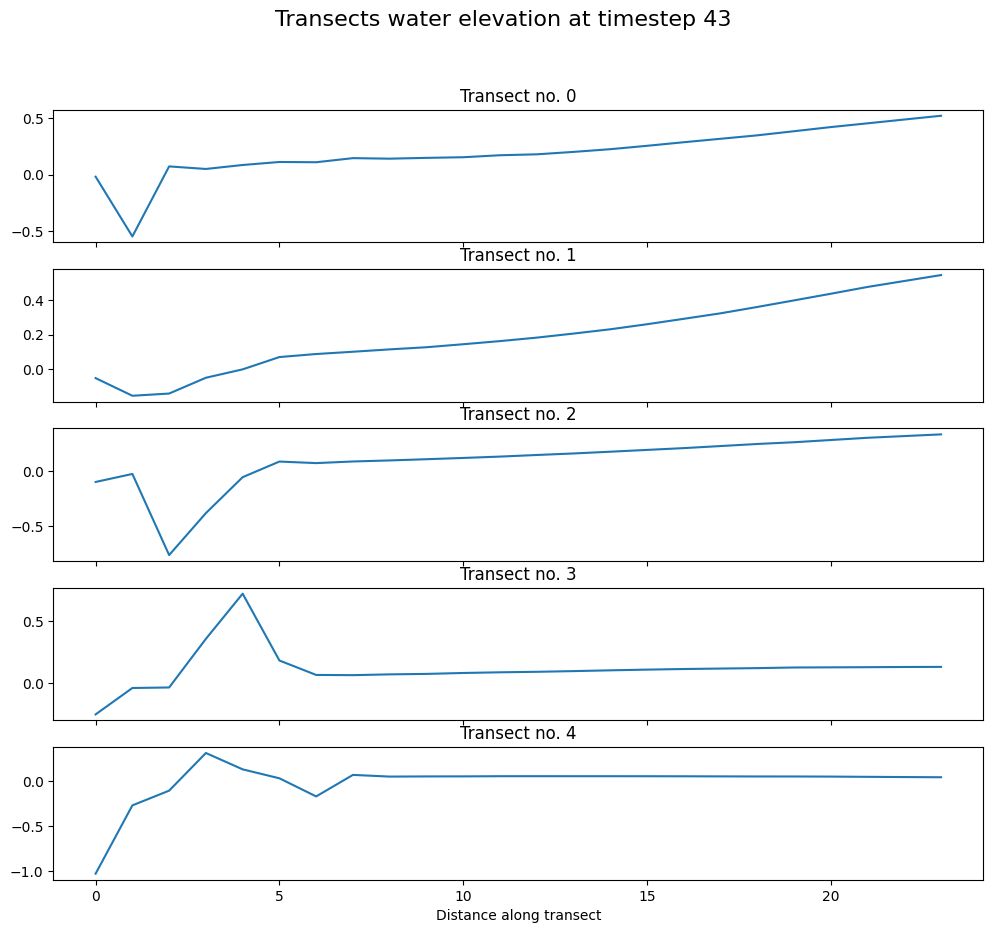

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
axes = np.array(axes).flatten()

xs = []
ys = []
for i in range(5):
    xs = []
    ys = []
    for point_x in arc_xs[1:]:
        xs.append(point_x[i])
    for point_y in arc_ys[1:]:
        ys.append(point_y[i])
    dfout2, rep = extract_ts_from_nc(nc_swan, list(zip(xs, ys)), variable='zeta', extractOut=False, closestIfDry=False)  
    time = dfout2.iloc[timestep].name
    transect = dfout2.iloc[timestep].values
    axes[i].set_ylim(-1, 1)
    axes[i].plot(transect)
    axes[i].set_title(f'Transect no. {i}')

axes[4].set_xlabel('Distance along transect')

fig.suptitle(f'Transects water elevation at timestep {timestep}', fontsize=16)

## Animation

In [31]:
from matplotlib.animation import FuncAnimation

In [35]:
data = nc_HS #nc_swan  
var = 'swan_HS' #'zeta'#'swan_HS' 

for i in tqdm(range(47), desc="Generating frames"):
        fig, ax = plt.subplots(figsize = (8,5), subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        constrained_layout=True)
        timestep=i
        # significant wave height
        plot_nc(nc_HS, 'swan_HS', levels = np.arange(0., 15., 0.01),
                background_map = True, cbar = True, cb_label = 'Significant Wave Height [m]',
                cmap = cmocean.cm.deep_r, ts = timestep, ax = ax, fig = fig)

        # Get the coordinates and wave direction data
        x = nc_DIR.variables['x'][:]
        y = nc_DIR.variables['y'][:]
        dir_data = nc_DIR.variables['swan_DIR'][timestep, :]

        # Convert from oceanographic convention (where waves come from) to mathematical (where arrows point)
        # In oceanographic convention, 0° is from North, 90° is from East
        # For plotting arrows, we need to convert to mathematical angles where 0° is East and goes counterclockwise
        #math_angles = (270 - dir_data) % 360
        math_angles_rad = np.radians(dir_data)

        # Calculate u and v components for arrows
        u = np.cos(math_angles_rad)
        v = np.sin(math_angles_rad)

        # Skip points to make the plot clearer - show arrows at every nth point
        n = 2
        ax.quiver(x[::n], y[::n], u[::n], v[::n], 
                        scale=80, width=0.001, color='white', 
                        alpha=0.65,
                        transform=ccrs.PlateCarree())

        # Plot trajectory line
        ax.plot(lons, lats, '+-', linewidth=0.5, color='red', markersize=5)

        # Plot points at each time step
        ax.set_xlim(-75., -72.2)
        ax.set_ylim(18., 20.2)

        ax.set_title('Wave Direction (arrows) and Height at timestep: '+str(timestep))





        """n = plot_nc(data, var, 
                levels = np.arange(0, 15., 0.05), 
                background_map = True, 
                cbar = True, 
                cb_label = 'Max water level [mMSL]', 
                cmap = cmocean.cm.balance, 
                ts = i,  # Use frame as timestep
                xlims=xlims, 
                ylims=ylims,
                ncvec = nc2, 
                dxvec=0.05, 
                dyvec=0.05, 
                vecsc=700)  # Pass the axis to plot on"""
        
        # Add frame number for reference
        #n.set_title(f'Timestep {i}')
        #fig = n.figure
        # Save the frame
        frame_file = f'animation/ts_{i}.png'
        fig.savefig(frame_file, dpi=500, bbox_inches='tight')
        plt.close(fig)

Generating frames: 100%|██████████| 47/47 [01:29<00:00,  1.91s/it]


In [36]:
import imageio
import os

title = 'ADCIRC+SWAN_HS+DIR_shifted_small.gif' #ADCIRC+SWAN_HS.gif'

def create_animation_with_imageio():
    print("Creating animation with imageio...")
    
    # Get all frame files
    frames = []
    for ts in range(47):
        frame_file = f'animation/ts_{ts}.png'
        if os.path.exists(frame_file):
            frames.append(frame_file)
        else:
            print(f"Warning: File {frame_file} does not exist!")
    
    if not frames:
        print("No frames found!")
        return
    
    print(f"Found {len(frames)} frames")
    
    # Create GIF
    images = []
    for frame in frames:
        try:
            images.append(imageio.imread(frame))
        except Exception as e:
            print(f"Error reading {frame}: {str(e)}")
    
    if images:
        print(f"Creating GIF with {len(images)} images")
        imageio.mimsave(title, images, fps=12, loop=0)
        print("Animation saved to " + title)
    else:
        print("No images could be loaded")

# Try the alternative method
try:
    import imageio
    create_animation_with_imageio()
except ImportError:
    print("imageio not installed. Try: pip install imageio")

Creating animation with imageio...
Found 47 frames
Creating GIF with 47 images
Animation saved to ADCIRC+SWAN_HS+DIR_shifted_small.gif


## Station Locations

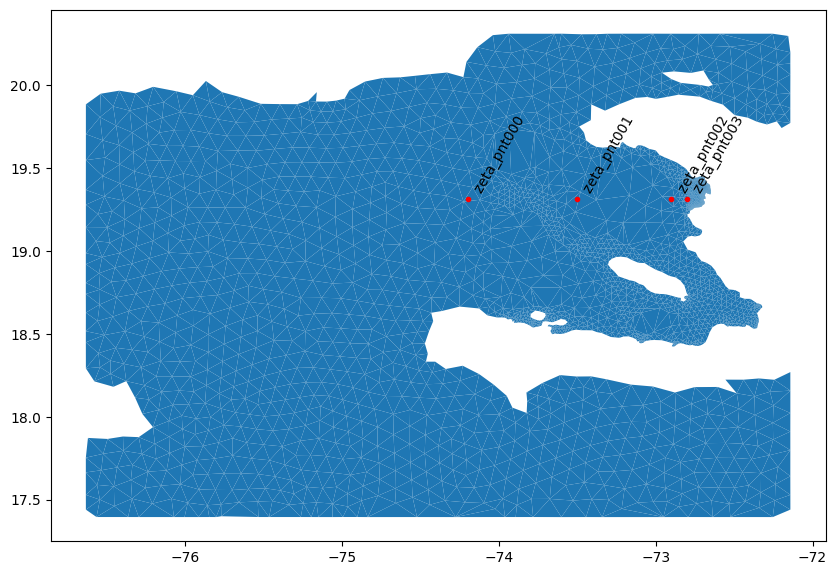

In [19]:
mesh = fort14togdf(root+'/fort.14', epsgIn=4326, epsgOut=4326, fileintype='fort.14')
fig, ax = plt.subplots(figsize = (10,8))
mesh.plot(ax = ax)
ax.scatter(xs, ys, color = 'r', marker = '.')

stations = dfout.columns.tolist()
for i, txt in enumerate(stations):
    ax.annotate('  '+txt, (xs[i], ys[i]), rotation=60)